In [1]:
import pandas as pd
import umap
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

In [3]:
# functions
def hyper_p(curr, genes, mat_hat_hat, index, temp):
    n = len(curr) # number of cluster genes
    M = len(genes) # total number of genes
    N = np.sum(mat_hat_hat[:,index]) # total number of pathway members
    x = np.sum(temp[:,index]) # observed overlap of cluster genes and pathway
    return 1 - hypergeom.cdf(x, M, n, N), x

# from: https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

def score_clusters(lab, M):
    lab_indices = np.empty(shape=(len(lab), len(np.unique(lab))))
    for i, L in enumerate(np.unique(lab)):
        lab_indices[:,i] = lab==L

    df = np.matmul((M.T), lab_indices)/np.sum(lab_indices, axis=0)
    return df

In [7]:
# specify umap params
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=30, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=2, n_components=2, n_epochs=1000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1,
     set_op_mix_ratio=1.0, spread=10, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)#, disconnection_distance=5)

In [4]:
# load data
expression = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
fgsea = pd.read_csv('./processed_data/for_plotting/fgsea_out.csv', index_col=0, encoding='windows-1254')
sele_paths = set(fgsea['pathway'])
leading_edge = pd.read_csv( './processed_data/for_plotting/leading_edge.csv', index_col=0)

In [5]:
# index top genes
index = np.array(np.sum(np.abs(expression)>1.3, axis=1)>0)
genes = np.array(expression.index)[index]
#genes = np.array(leading_edge['gene'])
M = np.array(expression.loc[genes])

In [8]:
# fit
embedding = reducer.fit_transform(M)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/gridsan/djuna/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'PuOr_r'#C2[i]
cm = plt.cm.get_cmap(COL, embedding.shape[0])
colors = [cm(int(x)) for x in range(embedding.shape[0])]

/state/partition1/slurm_tmp/23632928.0.0/ipykernel_2025537/3490485170.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding.shape[0])


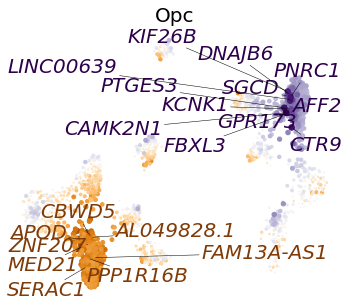

<Figure size 432x288 with 0 Axes>

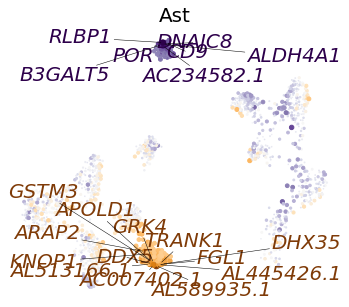

<Figure size 432x288 with 0 Axes>

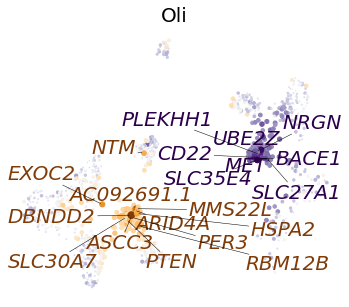

<Figure size 432x288 with 0 Axes>

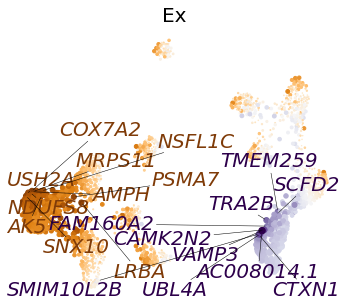

<Figure size 432x288 with 0 Axes>

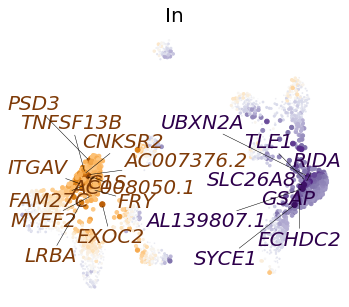

<Figure size 432x288 with 0 Axes>

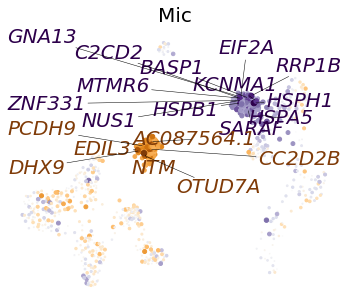

<Figure size 432x288 with 0 Axes>

In [12]:
from adjustText import adjust_text

celltypes = np.array(expression.columns)

for i, cell in enumerate(celltypes):
    plt.figure(figsize = (6,5))

    plt.scatter(embedding[:,0], embedding[:,1], c=M[:,i], cmap=COL, s = np.abs(M[:,i]*10))
    texts = []
    show = set(genes[np.argsort(-1*np.abs(M[:,i]))][:20])
    #order = np.argsort(-1*(M[:,i]))
    for x, txt in enumerate(genes):
         if txt in show:
            #C = colors[np.where([x in set([txt]) for x in list(show2)])[0][0]]
            w = np.where([f==txt for f in genes])[0][0]
            if M[x,i]<0:
                texts.append(plt.text(embedding[x,0], embedding[x,1], txt, style='italic', color = colors[0], fontsize=20))
            else:
                texts.append(plt.text(embedding[x,0], embedding[x,1], txt, style='italic', color = colors[-1], fontsize=20))
                
    adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    a = plt.gca()
    a.axis('off')
    plt.title(cell, fontsize=20)
    plt.savefig('./pdf_figures//'+str(cell)+'umap.pdf')
    plt.figure()
    

In [321]:

# celltypes = np.array(expression.columns)

# for i, cell in enumerate(celltypes):
#     plt.figure(figsize = (6,5))

#     plt.scatter(embedding[:,0], embedding[:,1], c=M[:,i], cmap='PuOr_r', s = np.abs(M[:,i]*10))
#     a = plt.gca()
#     a.axis('off')
#     plt.title(cell, fontsize=20)
#     plt.savefig('./pdf_figures//'+str(cell)+'umap.pdf')
#     plt.figure()
    

In [323]:
from matplotlib.colors import LinearSegmentedColormap

cm0 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#8491B4FF")], N=10)

cm1 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#E64B35FF")], N=10)

cm2 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#F39B7FFF")], N=10)

cm3 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#4DBBD5FF")], N=10)

cm4 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#00A087FF")], N=10)

cm5 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#3C5488FF")], N=10)

COL = [cm0, cm1, cm2, cm3, cm4, cm5]

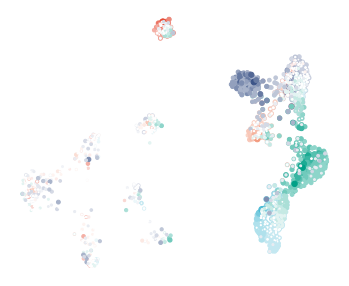

In [324]:
# show all together
plt.figure(figsize = (6,5))

for i, cell in enumerate(celltypes):
    
    index = np.where(M[:,i]<0)[0]
    plt.scatter(embedding[index,0], embedding[index,1], c=np.abs(M[index,i]), cmap=COL[i], s = np.abs(M[index,i]*10),label=cell)
    a = plt.gca()
    a.axis('off')
    plt.title(cell, fontsize=20)
    #plt.title(cell)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_down.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


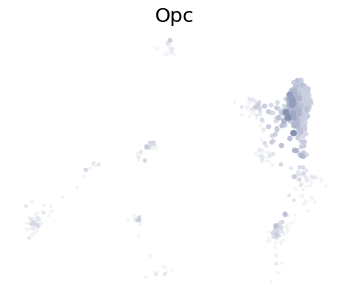

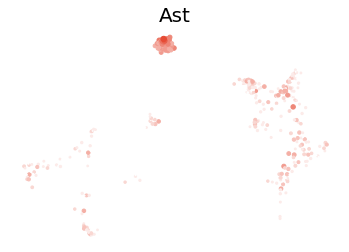

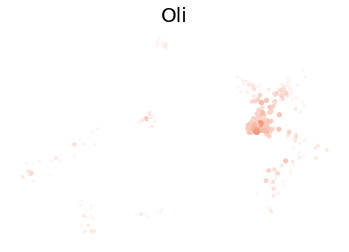

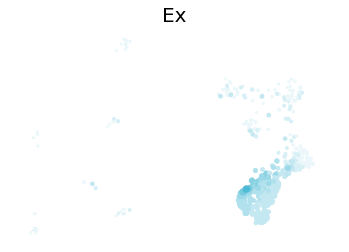

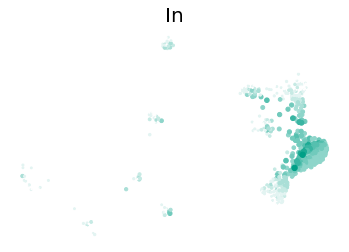

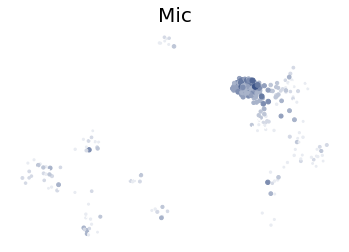

<Figure size 432x288 with 0 Axes>

In [347]:
# show all together
plt.figure(figsize = (6,5))

for i, cell in enumerate(celltypes):
    
    index = np.where(M[:,i]<0)[0]
    plt.scatter(embedding[index,0], embedding[index,1], c=np.abs(M[index,i]), cmap=COL[i], s = np.abs(M[index,i]*10),label=cell)
    a = plt.gca()
    a.axis('off')
    plt.title(cell, fontsize=20)
    #plt.title(cell)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_down.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


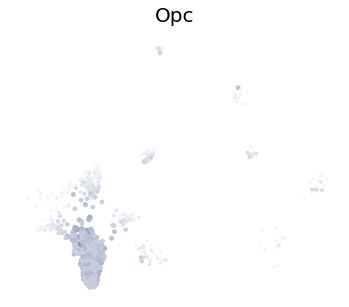

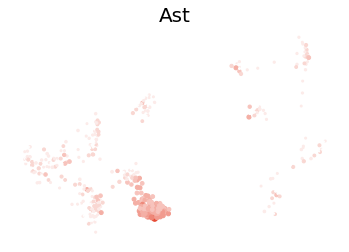

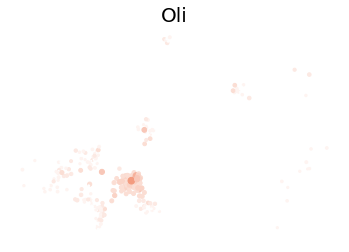

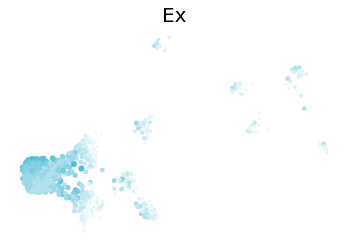

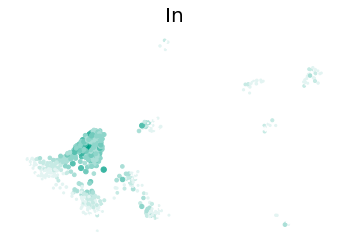

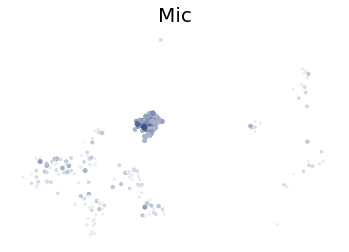

<Figure size 432x288 with 0 Axes>

In [325]:
# show all together
plt.figure(figsize = (6,5))

for i, cell in enumerate(celltypes):
    
    index = np.where(M[:,i]>0)[0]
    plt.scatter(embedding[index,0], embedding[index,1], c=np.abs(M[index,i]), cmap=COL[i], s = np.abs(M[index,i]*10),label=cell)
    a = plt.gca()
    a.axis('off')
    plt.title(cell, fontsize=20)
    #plt.title(cell)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_up.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


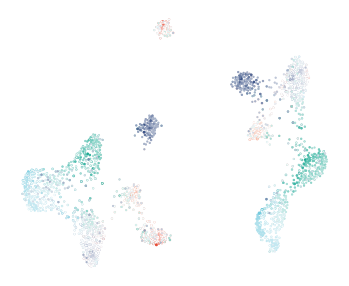

In [346]:
# show all together
plt.figure(figsize = (6,5))

for i, cell in enumerate(celltypes):
    
    #index = np.where(M[:,i]<0)[0]
    plt.scatter(embedding[:,0], embedding[:,1], c=np.abs(M[:,i]), cmap=COL[i], s = np.abs(M[:,i]*1),label=cell)
    a = plt.gca()
    a.axis('off')
    #plt.title(cell, fontsize=20)
    #plt.title(cell)
    #plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_down.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    #plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7457b899d0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

(-92.39809188842773, 88.68945846557617, -36.979742431640624, 66.38910522460938)

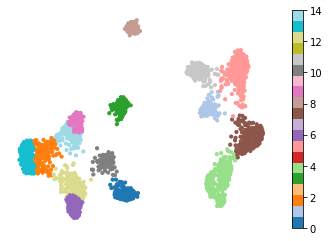

In [326]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture

i = 0
# plot cosine similarity ordered by label
#x = cosine_similarity(embedding)
#x.shape

#clusterer = SpectralClustering(24)#, #affinity='precomputed')
#lab = clusterer.fit_predict(M)
gm = GaussianMixture(n_components=15, covariance_type='full', random_state=0).fit(embedding)
lab = gm.predict(embedding)

plt.scatter(embedding[:,0], embedding[:,1], c=lab, cmap='tab20', s=10)#s = np.abs(expression[i][gene_index_a][gene_index2][gene_index3]*10))
plt.colorbar()
a = plt.gca()
a.axis('off')


In [16]:
content = pd.read_csv('../../../TsaiMadry_shared/clusters/GO_Biological_Process_2023_subset_mat.csv', index_col='Unnamed: 0')
content_T = np.array(content).T
content_T.shape

In [328]:

from scipy.stats import hypergeom
names = []
content_T = np.array(content).T
paths = np.array(content.index)

for i in np.unique(lab):
    curr = set(genes[lab==i])
    temp = content_T[np.array([x in curr for x in content.columns])]
    pvals = [hyper_p(curr, genes, content_T, x, temp) for x in range(content_T.shape[1])]
    counts = [x[1] for x in pvals]
    pvals = [x[0] for x in pvals]
    
    df = pd.DataFrame(np.concatenate((paths.reshape(-1,1), np.array(pvals).reshape(-1,1), np.array(counts).reshape(-1,1)), axis=1))
    df = df[df[1]<0.05]
    name1 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[0].split(' (')[0] 
    if df.shape[0]==2:
        name2 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[1].split(' (')[0] 
    #name3 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[2].split(' (')[0]
    #name4 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[3].split(' (')[0]
    #name5 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[4].split(' (')[0]
    #name = np.array(df.iloc[np.argsort(-1*np.array(df[2]))][0])[0].split(' (')[0] 
        names.append(name1+'\n'+name2+'\n')#+name3)#+'\n'+name4+'\n'+name5)
    elif df.shape[0]>2:
        name2 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[1].split(' (')[0] 
        name3 = np.array(df.iloc[np.argsort(np.array(df[1]))][0])[2].split(' (')[0]
        names.append(name1+'\n'+name2+'\n'+name3)#+'\n'+name4+'\n'+name5)
    else:
        names.append(name1)

dictionary = dict(zip(np.unique(lab), names))
N = np.array([dictionary[x] for x in lab])

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


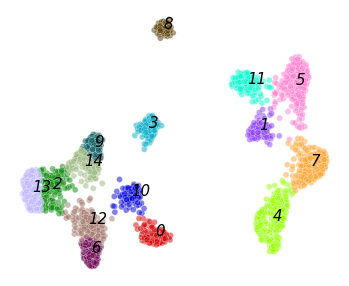

In [334]:
plt.figure(figsize = (6,5))

import seaborn as sns
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))

#for i in range(embedding.shape[0]):
order = np.argsort(lab)

sns.scatterplot(embedding[order,0], embedding[order,1], hue = N[order], palette=palette, legend=False, alpha=0.5)#, label = list(dictionary.values()))
legend = plt.legend(ncol=1, bbox_to_anchor=(1, 1), frameon=False, fontsize=12, scatterpoints=1, markerscale=2)

for i in range(len(palette)):
    x = np.mean(embedding[order][lab[order]==i,0])
    y = np.mean(embedding[order][lab[order]==i,1])
    
    plt.text(x,y, i, style='oblique',  c='black', fontsize=15)
    
a = plt.gca()
a.axis('off')
#plt.autoscale()

plt.savefig('./pdf_figures/cluster_overview.pdf', bbox_inches='tight')


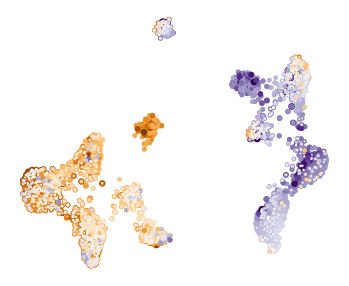

In [336]:
plt.figure(figsize = (6,5))
celltypes = np.array(expression.columns)

for i, cell in enumerate(celltypes):
    

    plt.scatter(embedding[:,0], embedding[:,1], c=M[:,i], cmap='PuOr_r', s = np.abs(M[:,i]*10))
    a = plt.gca()
    a.axis('off')
    #plt.title('All celltypes', fontsize=20)
  
plt.savefig('./pdf_figures//umap_exp_overview.pdf')
    #plt.figure()
    


In [333]:
export_legend(legend, './pdf_figures/legend.png')

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

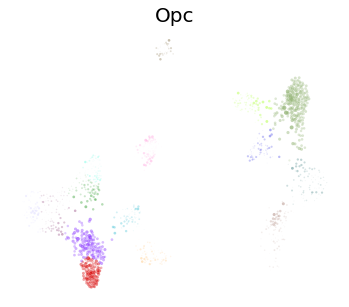

<Figure size 432x288 with 0 Axes>

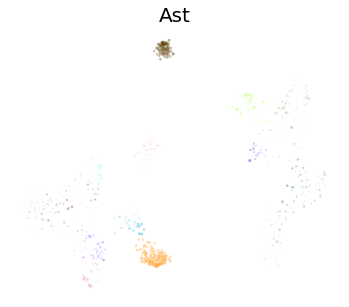

<Figure size 432x288 with 0 Axes>

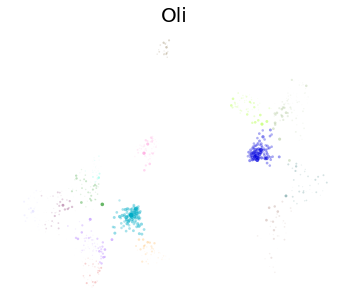

<Figure size 432x288 with 0 Axes>

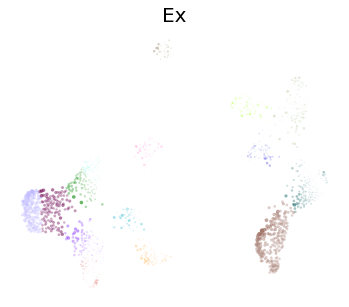

<Figure size 432x288 with 0 Axes>

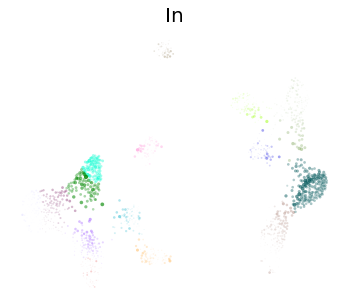

<Figure size 432x288 with 0 Axes>

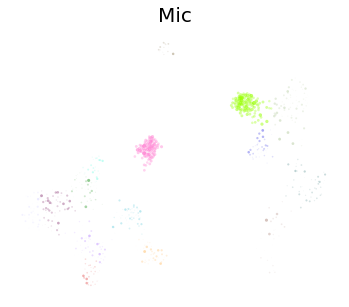

<Figure size 432x288 with 0 Axes>

In [337]:

celltypes = np.array(expression.columns)

for i, cell in enumerate(celltypes):
    plt.figure(figsize = (6,5))

    sns.scatterplot(embedding[:,0], embedding[:,1], hue = N, palette=palette, legend=False, s=np.abs(M[:,i]*5), alpha=np.abs(M[:,i])/np.max(np.abs(M)))

    a = plt.gca()
    a.axis('off')
    plt.title(cell, fontsize=20)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_clust.pdf')
    plt.figure()
    

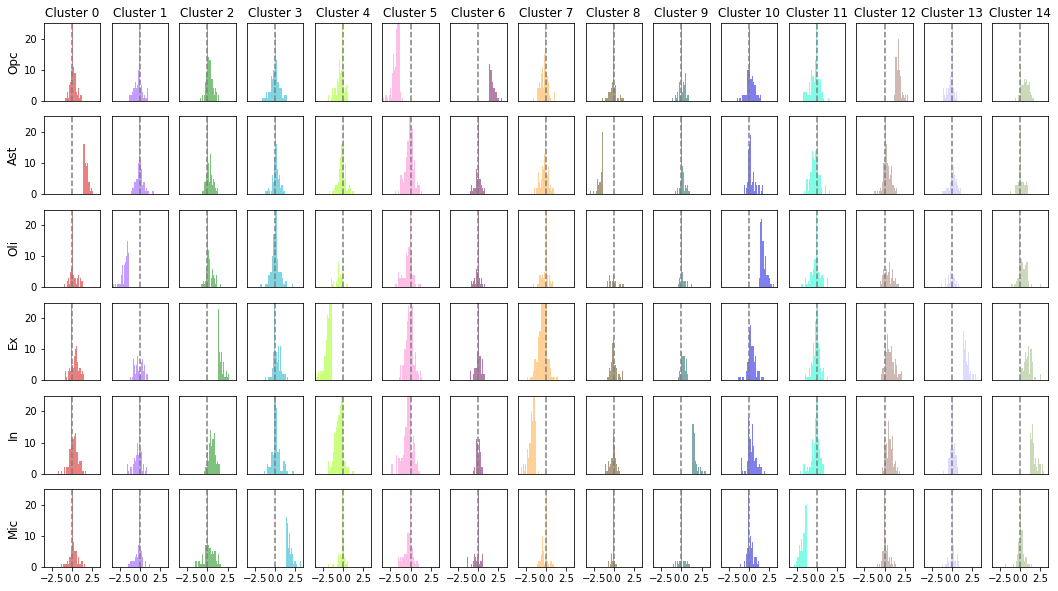

In [338]:
df = pd.DataFrame(score_clusters(lab, M))
df.index = celltypes
df.columns = np.unique(lab)

df['celltype'] = df.index
temp = pd.melt(df, id_vars='celltype')

fig, axs = plt.subplots(6, 15)
fig.set_size_inches(18, 10)

for x in range(len(celltypes)):

    for i in np.unique(lab):
        axs[x,i].hist(M.T[x][lab==i], alpha=0.5, color=palette[i], bins=20, label=str(i))
        #axs[x,i].axvline(x=np.mean(M.T[x][lab==i]), color=palette[i])
        axs[x,i].axvline(x=0, color='grey', linestyle='--')
        axs[x,i].set_xlim([-3.5,3.5])
        axs[x,i].set_ylim([0,25])
        #ax.yaxis.set_label_position("right")
        
        if x < 5:
            axs[x,i].xaxis.set_visible(False)
        if i > 0:
            axs[x,i].yaxis.set_visible(False)
            
    #plt.title(celltypes[x])
    #plt.legend()
    #plt.savefig('./pdf_figures//'+str(celltypes[x])+'hist.pdf')
    #plt.figure()
   
rows = ['{}'.format(col) for col in celltypes]
cols = ['Cluster {}'.format(row) for row in np.unique(lab)]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.savefig('./pdf_figures/cluster_hist.pdf')

In [340]:
from scipy import interpolate
N = 100000
out = np.empty((N, df.shape[0]*df.shape[1]))
out = np.vstack([score_clusters(np.random.permutation(lab), M).ravel() for i in range(N)])
true = score_clusters(lab, M).ravel()
pvals = []
for i in range(out.shape[1]):
    #print(i)
    val = true[i]
    x = out[:,i]
    if ((val>np.max(x)) | (val<np.min(x))):
        pvals.append(0)
    else:
        y = (rankdata(x)/N)
        func = interpolate.interp1d(x,y)

        if val>0:
            pvals.append((1-func(val)))
        else:
            pvals.append(float(func(val)))

In [341]:
df = pd.DataFrame(score_clusters(lab, M))
df.index = celltypes
df.columns = np.unique(lab)
df = df.T
df['cluster'] = df.index
temp = pd.melt(df, id_vars='cluster')
temp['pval'] = pvals

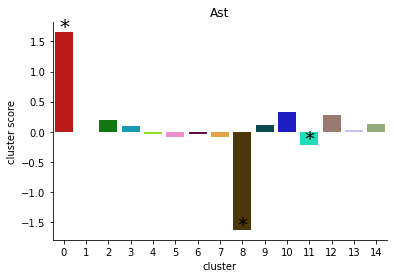

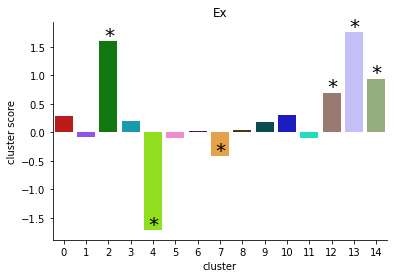

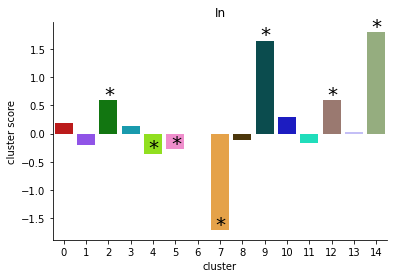

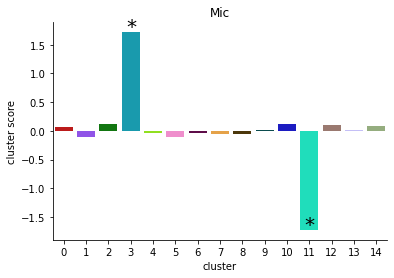

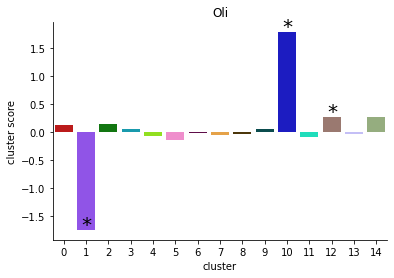

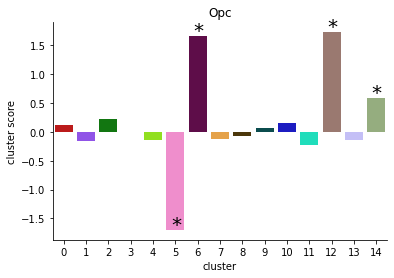

<Figure size 432x288 with 0 Axes>

In [342]:
for name in np.unique(temp['variable']):
    TE = temp.loc[temp['variable']==name]
    g = sns.barplot(data=TE,x='cluster', y='value', hue='cluster', palette=palette, dodge=False)
    plt.legend([],[], frameon=False)

    for i in range(len(np.array(TE['pval']))):
        p = np.array(TE['pval'])[i]
        if p<0.0001:
            g.text(TE.iloc[i]['cluster']-0.2,TE.iloc[i]['value'],'*', fontsize=20)
        #if p<0.001:
        #    g.text(TE.iloc[i]['cluster']-0.2,TE.iloc[i]['value'],'*', fontsize=15)
    sns.despine(top = True, right = True)
    plt.ylabel('cluster score')
    plt.title(name)
    plt.savefig('./pdf_figures/cluster_bars' + name + '.pdf')
    plt.figure()